# Homework 4
Section 8.4

Math 404

Winter 2020

Logan Schelly

In [1]:
import time
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#Copy/paste all the code from the previous assignment :(
class LinearModel(object):
    
    def __init__(self, F, Q, H, R, u):
        """
        Initialize the dynamical system models.
        
        Parameters
        ----------
        F : ndarray of shape (n,n)
            The state transition model.
        Q : ndarray of shape (n,n)
            The covariance matrix for the state noise.
        H : ndarray of shape (m,n)
            The observation model.
        R : ndarray of shape (m,m)
            The covariance matric for observation noise.
        u : ndarray of shape (n,)
            The control vector.
        """
        self.transition_model = F
        self.state_noise_covariance = Q
        self.observation_model = H
        self.observation_noise_covariance = R
        self.control_vector = u
        return
    
    
    def evolve(self,x0,N):
        """
        Compute the first N states and observations generated by the linear system.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state.
        N : integer
            The number of time steps to evolve.

        Returns
        -------
        states : ndarray of shape (n,N)
            States 0 through N-1, given by each column.
        obs : ndarray of shape (m,N)
            Observations 0 through N-1, given by each column.
        """
        #Unpack the variables.
        F = self.transition_model
        H = self.observation_model
        Q = self.state_noise_covariance
        R = self.observation_noise_covariance
        u = self.control_vector
        
        #Initialize space for states and observations.
        m, n = H.shape
        X = np.empty((n, N)) #states
        Y = np.empty((m, N)) #obs
        
        #Store the original state and observation.
        X[:, 0] = x0
        v0 = np.random.multivariate_normal(np.zeros(m), R) #observation noise
        Y[:, 0] = H.dot(x0) + v0
        
        #Iteratively calculate susequent states and observations
        for k in range(1,N):
            #Find the state noise.
            w = np.random.multivariate_normal(np.zeros(n), Q)
            #Update state with equation 8.10a
            X[:,k] = F.dot(X[:,k-1]) + u + w #G is I.
            #Find observation noise
            v = np.random.multivariate_normal(np.zeros(m), R)
            #Create next observation with equation 8.10b
            Y[:,k] = H.dot(X[:,k]) + v
        
        return X, Y #X is states, Y is obs
    
    
    def estimate(self,x0,P,y):
        """
        Compute the state estimates using the Kalman filter.
        If x0 and P correspond to time step k, then y is a sequence of
        observations starting at time step k+1.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state estimate.
        P : ndarray of shape (n,n)
            The initial error covariance matrix.
        y : ndarray of shape(m,N)
            Sequence of N observations (each column is an observation).

        Returns
        -------
        out : ndarray of shape (n,N)
            Sequence of state estimates (each column is an estimate).
        """
        F = self.transition_model
        #G=I is trivial
        u = self.control_vector
        Q = self.state_noise_covariance
        H = self.observation_model
        R = self.observation_noise_covariance
        
        N = y.shape[1]
        x = np.empty((x0.size, N))
        x_prev = x0
        
        for k, yk in enumerate(y.T):
            #predict
            xp = F.dot(x_prev) + u
            Pp = F.dot(P.dot(F.T)) + Q
            #update
            P = np.linalg.inv(
                    np.linalg.inv(Pp) 
                    + H.T.dot(np.linalg.solve(R, H))
            )
            x[:,k] = xp - P.dot(H.T.dot(np.linalg.solve(R, H.dot(xp)-yk)))

            x_prev = x[:,k]
        
        return x

In [3]:
dt = 0.1#seconds
Q = 0.1 * np.eye(4)
R = 5000 * np.eye(2)
x0 = np.array([0, 0, 300, 600])
g= -9.8

#Construct F.
F = np.eye(4)
#Set the up 2 off-diagonal to dt
F[np.r_[:2], 2+np.r_[:2]] = dt

#Construct u.
u = np.zeros(4)
u[-1] = g*dt

#Construct H
H = np.zeros((2, 4))
np.fill_diagonal(H, 1)

#1250 time steps.
N = 1250

#Make the linear model and evolve it.
lm = LinearModel(F, Q, H, R, u)
X, Y = lm.evolve(x0, N)

#Slice
Y_slice = Y[:,200:801]
X_slice = X[:,200:801]

n_obs = Y_slice.shape[1]
x_hat = np.empty((4, n_obs))
x_hat[:2,0] = Y_slice[:,0]

avg_velocities = np.diff(
    Y_slice[:,:9],
    axis=1,
    append=Y_slice[:,[9]]
)/dt
x_hat[2:,0] = avg_velocities.mean(axis=1)

P200 = 10**6 * Q
#Make a new linear model, so it will have the estimate method.
lm = LinearModel(F, Q, H, R, u)
#Do the estimation
x_hat[:,1:] = lm.estimate(x_hat[:,0], P200, Y_slice[:,1:])

## Exercise 8.12
Add a method ``KalmanFilter`` to the ``LinearModel`` class that computes the Kalman filter using the equations
$$
K_k = P_{k|k-1}H_k^{\intercal}(H_kP_{k|k-1}H_k^{\intercal} + R_k)^{-1} \hspace{2cm} \text{(8.25a)}\\
\hat{\mathbf{x}}_{k|k-1} + K_k(\mathbf{y}_k - H_k \hat{\mathbf{x}}_{k|k-1}) \hspace{4.2cm} \text{(8.25b)}\\
P_k = (I - K_k H_k)P_{k|k-1} \hspace{5cm} \text{(8.25c)}
$$.

In [4]:
class LinearModel(LinearModel):
    
    def KalmanFilter(self,x0,P,y):
        """
        Compute the state estimates using the Kalman filter.
        If x0 and P correspond to time step k, then y is a sequence of
        observations starting at time step k+1.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state estimate.
        P : ndarray of shape (n,n)
            The initial error covariance matrix.
        y : ndarray of shape(m,N)
            Sequence of N observations (each column is an observation).

        Returns
        -------
        out : ndarray of shape (n,N)
            Sequence of state estimates (each column is an estimate).
        """
        F = self.transition_model
        #G=I is trivial
        u = self.control_vector
        Q = self.state_noise_covariance
        H = self.observation_model
        R = self.observation_noise_covariance
        
        N = y.shape[1]
        I = np.eye(x0.size)
        x = np.empty((x0.size, N))
        x_prev = x0
        
        for k, yk in enumerate(y.T):
            #predict
            xp = F.dot(x_prev) + u
            Pp = F.dot(P.dot(F.T)) + Q
            #update
            S = H.dot(Pp.dot(H.T)) + R
            K = np.linalg.solve(S.T, H.dot(Pp.T)).T
            x[:,k] = xp + K.dot(yk - H.dot(xp))
            P = (I - K.dot(H)).dot(Pp)
            x_prev = x[:,k]
        
        return x

Repeat Exercise 8.11 using ``KalmanFilter`` instead of ``estimate``.
Compare the computation time and the accuracy of the results with those for ``estimate`` applied to the same problem.

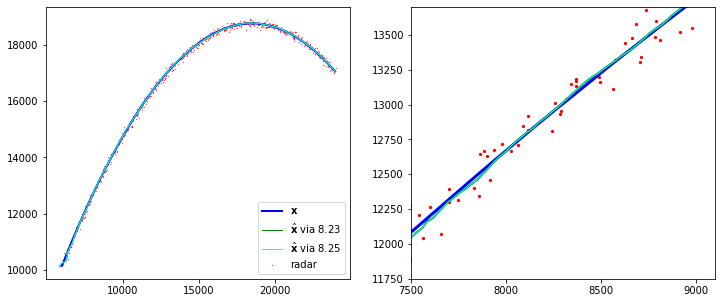

In [5]:
#Part (i) Make the initial condition for the estimate.
x_hatK = np.empty_like(x_hat)
x_hatK[:,0] = x_hat[:,0]

#part (ii) 
#Make a new linear model, so it will have the KalmanFilter method.
lm = LinearModel(F, Q, H, R, u)

#Obtain estimates
x_hatK[:,1:] = lm.KalmanFilter(x_hat[:,0], P200, Y_slice[:,1:])

#part(iii)
#plot kalman filter estimates vs true state sequence.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax1, ax2 = axes.ravel()

ax1.scatter(Y_slice[0], Y_slice[1], label='radar', color='red', s=.1)
ax1.plot(X_slice[0], X_slice[1], label=r'$\mathbf{x}$', color='blue', lw=2)
ax1.plot(x_hat[0], x_hat[1], label=r'$\hat{\mathbf{x}}$ via 8.23', color='green', lw=1)
ax1.plot(x_hatK[0], x_hatK[1], label=r'$\hat{\mathbf{x}}$ via 8.25', color='cyan', lw=1)
ax1.set_xticks([10000, 15000, 20000])
ax1.legend(loc='lower right')

ax2.scatter(Y_slice[0], Y_slice[1], color='red', s=5)
ax2.plot(X_slice[0], X_slice[1], color='blue', lw=3)
ax2.plot(x_hat[0], x_hat[1], color='green', lw=2)
ax2.plot(x_hatK[0], x_hatK[1], color='cyan', lw=1)
ax2.set_xlim([7500, 9100])
ax2.set_xticks([7500, 8000, 8500, 9000])
ax2.set_ylim([11750, 13700])

plt.show()

In [6]:
#Compare computation time.
t = time.time()
lm.estimate(x_hat[:,0], P200, Y_slice[:,1:])
estimate_time = time.time() - t
print(estimate_time, "seconds for estimate()")

t = time.time()
lm.KalmanFilter(x_hat[:,0], P200, Y_slice[:,1:])
kalman_filter_time = time.time() - t
print(kalman_filter_time, "seconds for KalmanFilter()")

0.041008710861206055 seconds for estimate()
0.020931482315063477 seconds for KalmanFilter()


In [7]:
#Compare accuracy.
tot_sq_err_estimate = ((x_hat-X_slice)**2).sum()
print(tot_sq_err_estimate,"is the total squared error for estimate()")
tot_sq_err_kalman_filter = ((x_hatK-X_slice)**2).sum()
print(tot_sq_err_kalman_filter, "is the total squared error for KalmanFilter()")

1174976.0189005963 is the total squared error for estimate()
1174976.0189005956 is the total squared error for KalmanFilter()


## Exercise 8.13
Add a method to the linear model class that predicts the next $k$ states, given a current state estimate, but in the absence of observations.  Do so by implementing the following function:

In [8]:
class LinearModel(LinearModel):
    
    def predict(self, x, k):
        """
        Predict the next k states in the absence of observations.
        
        Parameters
        ----------
        x : ndarray of shape (n,)
            The current state of the estimate.
        k : integer
            The number of states to predict.
        
        Returns
        -------
        out : ndarray of shape (n,k)
            The next k predicted states.
        """
        F = self.transition_model
        u = self.control_vector
        n = x.size
        out = np.empty((n, k))
        out[:, 0] = x
        for i in range(1, k):
            x_prev = out[:,i-1]
            out[:, i] = F.dot(x_prev) + u
        return out

## Exercise 8.14
Using the final state estimate $\hat{\mathbf{x}}_{800}$ that you obtained in Problem 11, predict the future states of the projectile until it hits the ground.  Predicting approximately the next 450 states should be sufficient.

Plot the actual state sequence together with the predicted state sequence (as a yellow curve), and observe how near the prediction is to the actual point of impact.  Your results should be similar to those shown in Figure 8.4.

9


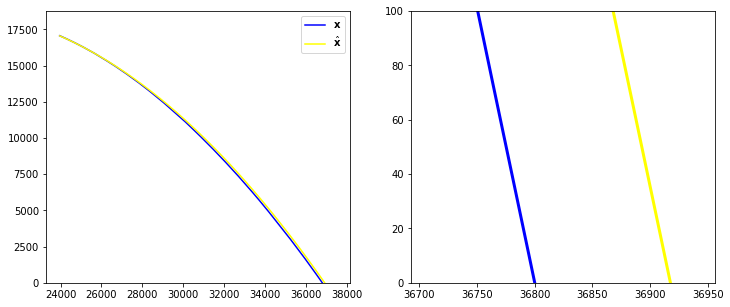

In [9]:
#Make a new linear model, so it will have the predict() method.
lm = LinearModel(F, Q, H, R, u)
x_predicted = lm.predict(x_hat[:,-1], 450)

#Plot the predicted x versus the true one.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax1, ax2 = axes.ravel()

ax1.plot(X[0,800:], X[1,800:], label=r'$\mathbf{x}$', color='blue')
ax1.plot(x_predicted[0], x_predicted[1], label=r'$\hat{\mathbf{x}}$', color='yellow')
ax1.set_ylim((0, X[1, 800:].max()*1.1))
ax1.legend()

#Select the stuff near impact.
zoom_height = 100
mask = X[1] <= zoom_height*2
mask &= X[1] >= -zoom_height
print(mask.sum())
roughly_halfway = np.argmax(X[1])
mask &= X[0] >= X[1, roughly_halfway]

ax2.plot(X[0,mask], X[1,mask], color='blue', lw=3)

#Select same stuff for predicted x.
mask = x_predicted[1] <= zoom_height*2
mask &= x_predicted[1] >= -zoom_height
#No need for halfway stuff because predictions happen well above ground.
ax2.plot(x_predicted[0, mask], x_predicted[1, mask], color='yellow', lw=3)


ax2.set_ylim((0, zoom_height))
plt.show()

## Exercises 8.15 & 8.16
(Exercise 8.15 doesn't ask us to do anything...)

In the absence of observations, we can also reverse the system and iterate backward in time to infer information about states of the system prior to measured observations.  The system is reversed by
$$
\mathbf{x}_k = F^{-1}(\mathbf{x}_{k+1} - \mathbf{u} - \boldsymbol{\varepsilon}_{k+1}).
$$
Considering again that $\mathbb{E}[\varepsilon_k]=0$ at any time $k$, we can ignore this term, simplifying the recursive estimation backward in time.

Add a function to the ``LinearModel`` class that rewinds the system from a given estimate, returning predictions for the previous states.  Do so by implementing the following function:

In [10]:
class LinearModel(LinearModel):
    
    def rewind(self, x, k):
        """
        Predict the k states preceding the current state estimate x.
        
        Parameters
        ----------
        x : ndarray of shape (n,)
            The current state of the estimate.
        k : integer
            The number of preceding states to predict.
        
        Returns
        -------
        out : ndarray of shape (n,k)
            The k preceding predicted states.
        """
        F = self.transition_model
        u = self.control_vector
        n = x.size
        out = np.empty((n, k))
        out[:,-1] = x
        for i in range(k-2, -1, -1):
            x_prev = out[:,i+1]
            out[:, i] = np.linalg.solve(F, x_prev - u)
        return out

## Exercise 8.17
Returning to the projectile example, we can now predict the point of origin.

### Part (i)
 Using your state estimate $\hat{\mathbf{x}}_{250}$, predict the point of origin of the projectile along with all states leading up to time step 250.  (The point of origin is the first point along the trajectory where the $y$ coordinate is 0.)

In [11]:
#Re-instantiate a linear model so we have the rewind method.
lm = LinearModel(F, Q, H, R, u)

#We tweak only one part of this, and then do it all over again for pt. iv
def ex817pt1(start_point=250):
    shifted_start = start_point - 200 #x_hat starts 200 steps in.
    enough_steps = int(start_point * 6 // 5)
    return lm.rewind(x_hat[:,shifted_start], enough_steps)

#300 should be enough steps
x_rw = ex817pt1()

### Part (ii)
Plot these predicted states in yellow together with the original state sequence in blue.

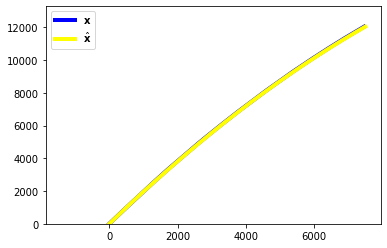

In [12]:
def ex817pt2(x_rw, start_point=250, title=None):
    plt.plot(X[0,:start_point], X[1,:start_point], label=r'$\mathbf{x}$', color='blue', lw=4)
    plt.plot(x_rw[0], x_rw[1], label=r'$\hat{\mathbf{x}}$', color='yellow', lw=4)
    plt.ylim((0, X[1,start_point]*1.1))
    plt.legend(loc='upper left')
    if title:
        plt.title(title)
    plt.show()
    
ex817pt2(x_rw)

### Part (iii)
Zoom in to see how accurate your prediction is.  Your plots should be similar to Figure 8.5.

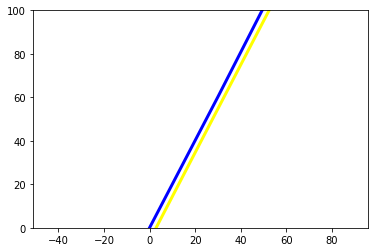

In [13]:
def ex817pt3(x_rw, title=None):
    #Select the stuff near impact.
    zoom_height = 100
    mask = X[1] <= zoom_height*2
    mask &= X[1] >= -zoom_height
    roughly_halfway = np.argmax(X[1])
    mask &= X[0] <= X[0, roughly_halfway]

    plt.plot(X[0,mask], X[1,mask], color='blue', lw=3)

    #Select same stuff for predicted x.
    mask = x_rw[1] <= zoom_height*2
    mask &= x_rw[1] >= -zoom_height
    #No need for halfway stuff because predictions happen well above ground.
    plt.plot(x_rw[0, mask], x_rw[1, mask], color='yellow', lw=3)


    plt.ylim((0, zoom_height))
    
    if title:
        plt.title(title)
        
    plt.show()

ex817pt3(x_rw)

### Part (iv)
Repeat the prediction starting with $\hat{\mathbf{x}}_{600}$.  Compare to the previous results.  Which is better? Why?

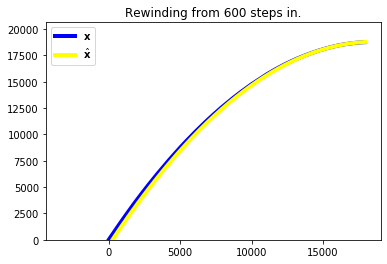

In [14]:
#I hate when they make us repeat an exercise with ONE SMALL THING TWEAKED,
#But they never tell us until we've completed one.
x_rw = ex817pt1(start_point=600)
ex817pt2(x_rw, start_point=600,  title="Rewinding from 600 steps in.")

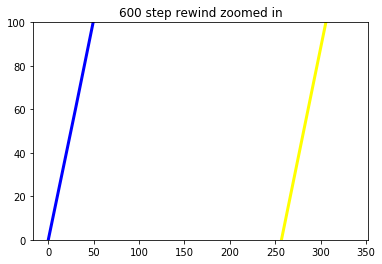

In [15]:
ex817pt3(x_rw, title='600 step rewind zoomed in')

## Exercise 8.18
Add a method ``SquareRootFilter`` to the ``LinearModel`` class that computes the Kalman filter using the algorithm described in Section 8.4.3.  Hint: the mehtod ``numpy.linalg.cholesky`` may be useful.

In [16]:
from scipy import linalg as la #has a matrix sqrt algorithm.

class LinearModel(LinearModel):
    
    def SquareRootFilter(self,x0,P,y):
        """
        Compute the state estimates using the square root algorithm variation of the Kalman filter.
        If x0 and P correspond to time step k, then y is a sequence of
        observations starting at time step k+1.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state estimate.
        P : ndarray of shape (n,n)
            The initial error covariance matrix.
        y : ndarray of shape(m,N)
            Sequence of N observations (each column is an observation).

        Returns
        -------
        out : ndarray of shape (n,N)
            Sequence of state estimates (each column is an estimate).
        """
        F = self.transition_model
        #G=I is trivial
        u = self.control_vector
        Q = self.state_noise_covariance
        H = self.observation_model
        R = self.observation_noise_covariance
        
        N = y.shape[1]
        x = np.empty((x0.size, N))
        x_prev = x0
        
        #Compute the Cholesky decomposition S_0 of P_0.
        S_prev = np.linalg.cholesky(P) # step (ii)
        #Compute a square root of Q
        T = la.sqrtm(Q) #step (iv), but the same each time.
        V = la.cholesky(R, lower=True) #step (vii), but the same each time.
        
        for k, yk in enumerate(y.T):
            M = np.hstack([F.dot(S_prev), T]) #step (iv) continued
            Sp = la.cholesky(M.dot(M.T), lower=True) # step (v)
            
            #predict -- step (vi)
            Pp = Sp.dot(Sp.T)
            xp = F.dot(x_prev) + u #G=I
            
            L = la.cholesky(H.dot(Pp.dot(H.T)) + R, lower=True) #step (vii)
            I = np.eye(Sp.shape[0])
            
            #step (viii)
            LpVinvHSp = la.solve_triangular(L+V, H.dot(Sp), lower=True)
            LTinvLpVinvHSp = la.solve_triangular(L.T, LpVinvHSp, lower=False)
            S = Sp@(I - Sp.T.dot(H.T.dot(LTinvLpVinvHSp)))
            
            #step (ix)
            LinvHPpT = la.solve_triangular(L, H.dot(Pp.T), lower=True)
            LTinvLinvHPpT = la.solve_triangular(L.T, LinvHPpT)
            PpHTLinvTLinv = LTinvLinvHPpT.T #using transpose rules.
            K = PpHTLinvTLinv
            
            #update
            x[:,k] = xp + K.dot(yk - H.dot(xp))
            P = S.dot(S.T)
            
            S_prev = S
            x_prev = x[:,k]
        
        return x

Repeat Exercise 8.11 using ``SquareRootFilter``.  Compare the computation time and accuracy results with those for ``estimate`` and ``KalmanFilter`` applied to the same problem.

In [17]:
#Part (i) Make the initial condition for the estimate.
x_hatS = np.empty_like(x_hat)
x_hatS[:,0] = x_hat[:,0]

#part (ii) 
#Make a new linear model, so it will have the SquareRoot method.
lm = LinearModel(F, Q, H, R, u)

#Obtain estimates
x_hatS[:,1:] = lm.SquareRootFilter(x_hat[:,0], P200, Y_slice[:,1:])

#part(iii)
#plot kalman filter estimates vs true state sequence.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax1, ax2 = axes.ravel()

ax1.scatter(Y_slice[0], Y_slice[1], label='radar', color='red', s=.1)
ax1.plot(X_slice[0], X_slice[1], label=r'$\mathbf{x}$', color='blue', lw=2)
ax1.plot(x_hatS[0], x_hatS[1], label=r'$\hat{\mathbf{x}}$ via 8.33', color='orange', lw=1)
ax1.set_xticks([10000, 15000, 20000])
ax1.legend(loc='lower right')

ax2.scatter(Y_slice[0], Y_slice[1], color='red', s=5)
ax2.plot(X_slice[0], X_slice[1], color='blue', lw=3)
ax2.plot(x_hatS[0], x_hatS[1], color='orange', lw=2)
ax2.set_xlim([7500, 9100])
ax2.set_xticks([7500, 8000, 8500, 9000])
ax2.set_ylim([11750, 13700])

plt.show()

In [18]:
#Compare computation time.
print(estimate_time, "seconds for estimate()")
print(kalman_filter_time, "seconds for KalmanFilter()")

t = time.time()
lm.SquareRootFilter(x_hat[:,0], P200, Y_slice[:,1:])
root_filter_time = time.time() - t
print(root_filter_time, "seconds for SquareRootFilter()")

0.041008710861206055 seconds for estimate()
0.020931482315063477 seconds for KalmanFilter()
0.13912653923034668 seconds for SquareRootFilter()


In [19]:
#Compare accuracy.
print(tot_sq_err_estimate,"is the total squared error for estimate()")
print(tot_sq_err_kalman_filter, "is the total squared error for KalmanFilter()")
tot_sq_err_root_filter = ((x_hatS-X_slice)**2).sum()
print(tot_sq_err_root_filter, "is the total squared error for SquareRootFilter()")

1174976.0189005963 is the total squared error for estimate()
1174976.0189005956 is the total squared error for KalmanFilter()
1174976.0189005956 is the total squared error for SquareRootFilter()
